In [20]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from typing_extensions import TypedDict
import os
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from IPython.display import Markdown

In [2]:
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


llm=ChatGroq(model="qwen-2.5-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003688726, 'queue_time': 0.225231625, 'total_time': 0.053688726}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-2913bdbf-4470-4dff-87b9-c54c47798a92-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

In [3]:
# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["Bullish", "Bearish", "Sideways"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


In [4]:
# State
class State(TypedDict):
    input: str
    decision: str
    output: str

In [13]:
# Nodes
def llm_call_1(state: State):
    """Suggest Futures and Options stratergy for a Bullish Market"""

    result = llm.invoke("Futures and Options stratergy for" + state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Suggest Futures and Options stratergy for a Bearish Market"""

    print("LLM call 2 is called")

    result = llm.invoke("Futures and Options stratergy for" + state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Suggest Futures and Options stratergy for a Sideways Market"""

    result = llm.invoke("Futures and Options stratergy for" + state["input"])
    return {"output": result.content}

In [14]:
def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to Bullish, Bearish, or Sideways based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}

In [15]:
# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "Bullish":
        return "llm_call_1"
    elif state["decision"] == "Bearish":
        return "llm_call_2"
    elif state["decision"] == "Sideways":
        return "llm_call_3"

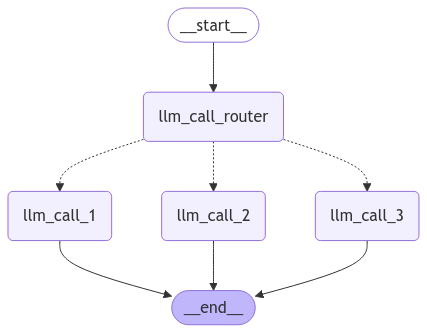

In [16]:
# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [21]:
# Invoke
state = router_workflow.invoke({"input": "Suggest a stratergy for a bullish market"})
Markdown(state["output"])

In a bullish market, the anticipation is that the prices of the underlying assets will rise. Here are a few strategies you can consider using futures and options to capitalize on this expectation:

### 1. **Bull Call Spread**
This strategy involves buying a call option at a lower strike price and selling a call option at a higher strike price. This approach limits the risk and the potential profit but is less expensive than buying a single call option outright. It is particularly suitable when you expect the underlying asset to rise but are uncertain about the magnitude of the rise.

### 2. **Bull Put Spread**
Similar to the Bull Call Spread, but with put options. You buy a put option at a higher strike price and sell a put option at a lower strike price. This strategy is effective if you expect the market to rise moderately.

### 3. **Buying Call Options**
This is a straightforward strategy where you buy call options on the underlying assets. If the price of the asset rises, the value of the call options will increase, allowing you to profit from the difference.

### 4. **Covered Call Writing**
If you own the underlying asset, you can sell (or write) call options on that asset. This strategy is less aggressive and generates income through premiums, but it limits the upside potential if the stock price rises significantly.

### 5. **Bull Futures Spread**
This involves buying a futures contract with a near-term expiration and simultaneously selling a futures contract with a longer-term expiration. This can be effective if you expect the short-term price to rise more than the long-term price.

### 6. **Buying Futures Contracts**
Similar to buying call options, you can directly buy futures contracts if you expect the underlying asset's price to rise. This strategy has a higher risk due to the leverage involved in futures trading, but it also offers the potential for high returns.

### Key Considerations:
- **Risk Tolerance:** Consider your risk tolerance and financial capacity to absorb potential losses.
- **Market Conditions:** Always monitor market conditions and economic indicators that might affect the market's direction.
- **Execution:** Ensure that you have a plan for how to enter and exit trades, and consider using stop-loss orders to manage risk.
- **Research:** Regularly review and research the underlying assets and the broader market environment.

### Important Note:
Each of these strategies has its own risk profile and potential reward. It's crucial to understand these well and possibly consult with a financial advisor before implementing any of these strategies, especially if you're not familiar with futures and options trading.